In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [2]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [3]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A



def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

In [4]:
kernel_name = "Matern"

In [5]:
if kernel_name == "Matern":
    # Defining the second order elliptic operators 
    def matern_kernel(x, y, length_scale):
        r = jnp.sqrt(jnp.sum((x - y) ** 2))
        return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

    vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
    # Now we apply vmap to the result to vectorize over the rows of the first argument
    vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

    # Defining the second order elliptic operators 
    def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
        r = jnp.sqrt((x_1 - y_1) ** 2 + (x_2 - y_2) ** 2)
        return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

    matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))

    def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])

        nu = 5/2
        l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
        l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
        l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
        return -(l_1 + l_2)

    def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])
        
        nu = 5/2
        l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_1 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_1)
        l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = jnp.where(jnp.allclose(x,y), -nu/(length_scale**2*(nu-1)), l_2)
        return -(l_1 + l_2)

    def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
        x = jnp.hstack([x_1, x_2])
        y = jnp.hstack([y_1, y_2])
        
        nu = 5/2
        l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_1 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_1)
        
        l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        l_2 =  jnp.where(jnp.allclose(x,y), -4*nu**2/((2-3*nu+nu**2))/length_scale**4, l_2)

        return -(l_1 + l_2)
elif kernel_name == "RBF":
    # RBF kernel
    def matern_kernel(x, y, length_scale):
        r =jnp.sum((x - y) ** 2)
        return jnp.exp(-r/length_scale**2)

    vmap_kernel_row = vmap(matern_kernel, in_axes=(None, 0, None))
    # Now we apply vmap to the result to vectorize over the rows of the first argument
    vmap_kernel = jit(vmap(vmap_kernel_row, in_axes=(0, None, None)))

    # Defining the second order elliptic operators 
    def matern_kernel_2d(x_1, x_2, y_1, y_2, length_scale):
        r =(x_1 - y_1) ** 2 + (x_2 - y_2) ** 2
        return  jnp.exp(-r/length_scale**2)

    matern_kernel_tensor = jit(vmap(vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes=(0, None, None, None, None)))
    def neg_laplacian_x(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(matern_kernel_2d, argnums=0), argnums = 0)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(matern_kernel_2d, argnums=1), argnums = 1)(x_1, x_2, y_1, y_2, length_scale)
        return -(l_1 + l_2)

    def neg_laplacian_y(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(matern_kernel_2d, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(matern_kernel_2d, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)
        return -(l_1 + l_2)

    def double_neg_laplacian(x_1, x_2, y_1, y_2, length_scale):
        l_1 = grad(grad(neg_laplacian_x, argnums=2), argnums = 2)(x_1, x_2, y_1, y_2, length_scale)
        l_2 = grad(grad(neg_laplacian_x, argnums=3), argnums = 3)(x_1, x_2, y_1, y_2, length_scale)

        return -(l_1 + l_2)
else:
    print("Error, kernel name not recognize")

In [6]:
double_neg_laplacian_tensor = jit(vmap(vmap(vmap(vmap(double_neg_laplacian, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_x_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_x, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))
neg_laplacian_y_tensor = jit(vmap(vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (None, 0, None, None, None)), in_axes = (0, None, None, None, None)))

In [7]:
neg_laplacian_y_partial = vmap(vmap(vmap(neg_laplacian_y, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None, None))
matern_kernel_partial = vmap(vmap(vmap(matern_kernel_2d, in_axes=(None, None,None, 0, None)), in_axes=(None, None, 0, None, None)), in_axes = (0, 0, None, None,None))

In [8]:
@jit
def L_b_xy_tensor(x_1,x_2, y_1, y_2,length_scale, epsilon,b_1, b_2):
    return epsilon**2*double_neg_laplacian_tensor(x_1,x_2, y_1, y_2,length_scale) + epsilon*b_2[None, None]*neg_laplacian_x_tensor(x_1,x_2, y_1, y_2, length_scale) + epsilon*b_1[:, :, None, None]*neg_laplacian_y_tensor(x_1,x_2, y_1, y_2, length_scale) + b_1[:, :, None, None]*b_2[None, None]*matern_kernel_tensor(x_1,x_2, y_1, y_2, length_scale)
@jit
def L_b_y_partial(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_partial(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_partial(x_1, x_2, y_1, y_2, length_scale))

@jit 
def L_b_y_tensor(x_1, x_2, y_1, y_2, length_scale, epsilon, b_1):
    return  epsilon*neg_laplacian_y_tensor(x_1, x_2, y_1, y_2, length_scale) + jnp.multiply(b_1[None], matern_kernel_tensor(x_1, x_2, y_1, y_2, length_scale))

In [9]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values

In [10]:
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [11]:
@jit
def build_matrices(boundary_points,x,y,length_scale, b_matrix, nu):
    n_boundary = boundary_points.shape[0]
    n_points = x.shape[0]
    theta_11 = vmap_kernel(boundary_points, boundary_points, length_scale)
    theta_22_tensor = L_b_xy_tensor(x, y,x,y, length_scale, nu, b_matrix, b_matrix)
    theta_12_tensor = L_b_y_partial(boundary_points[:, 0],boundary_points[:, 1],  x, y, length_scale, nu, b_matrix)

    theta_22_dst_tensor = double_dst_2d(theta_22_tensor)
    theta_12_dst_tensor  = vmap_dst_2d(theta_12_tensor)

    theta_12_dst = jnp.reshape(theta_12_dst_tensor, (n_boundary,n_points*n_points))
    theta_22_dst = jnp.reshape(theta_22_dst_tensor, shape= ( n_points*n_points, n_points*n_points))
    theta = jnp.block([[theta_11, theta_12_dst], [theta_12_dst.T, theta_22_dst]])

    return theta, theta_11, theta_12_dst, theta_22_dst

def solve(theta, boundary_condition, coef_forcing, s_decay, reg_bc = 1e-10, reg = 1e-7):
    n_points = coef_forcing.shape[0]
    n_boundary = boundary_condition.shape[0]
    rhs = jnp.hstack([boundary_condition, jnp.reshape(coef_forcing, (n_points)*(n_points))])

    # Adaptive nugget
    decay_nugget =  (jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1e-10
    decay_nugget = decay_nugget.reshape((n_points)*(n_points))**(s_decay)
    nugget = jnp.hstack([jnp.ones(n_boundary)*reg_bc, decay_nugget*reg])

    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a='pos')
    return alpha


def create_interior(x, y):
    # Use meshgrid to create the grid of pairs
    A, B = jnp.meshgrid(x, y, indexing='ij')

    # Combine A and B into pairs
    interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
    return interior

def predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix):
    n_eval = x_eval.shape[0]
    n_points =x.shape[0]
    interior_eval = create_interior(x_eval, y_eval)
    K_interior = L_b_y_tensor(x_eval, y_eval, x, y, length_scale, nu, b_matrix).reshape(n_eval*n_eval, n_points, n_points)
    K_interior = vmap_dst_2d(K_interior)
    K_interior = K_interior.reshape(-1, (n_points)*(n_points))

    K_eval_bc = vmap_kernel(interior_eval, boundary_points, length_scale)
    K_eval = jnp.hstack([K_eval_bc, K_interior])


    pred = jnp.dot(K_eval, alpha)
    pred_grid = jnp.reshape(pred, (n_eval, n_eval))

    return pred_grid, pred
    


# Elliptic PDE

In [12]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


We will consider 


We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u +u&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(\pi^2(l^2 + k^2) + 1)\sin(\pi k x) \sin(\pi l y) 


In [51]:
key = random.PRNGKey(647023)
key = random.PRNGKey(558)


n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1e-1
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**2))+ 1.5)
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**2))+ 1.5)
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
b = lambda x, y: 1.0
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))


Number of coefficients:  128


In [52]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values

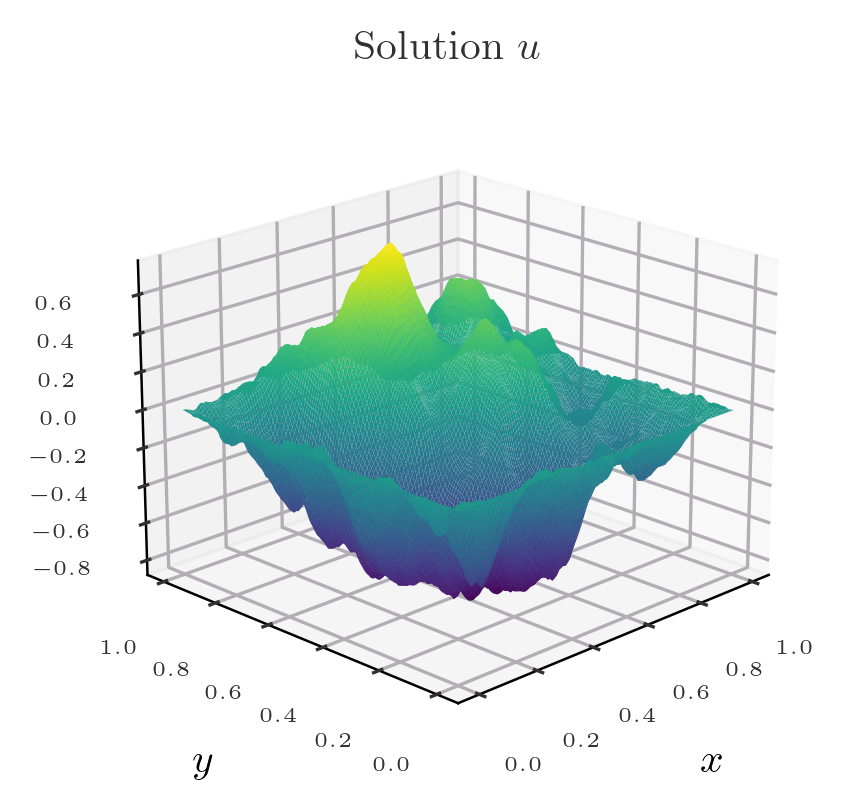

In [53]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

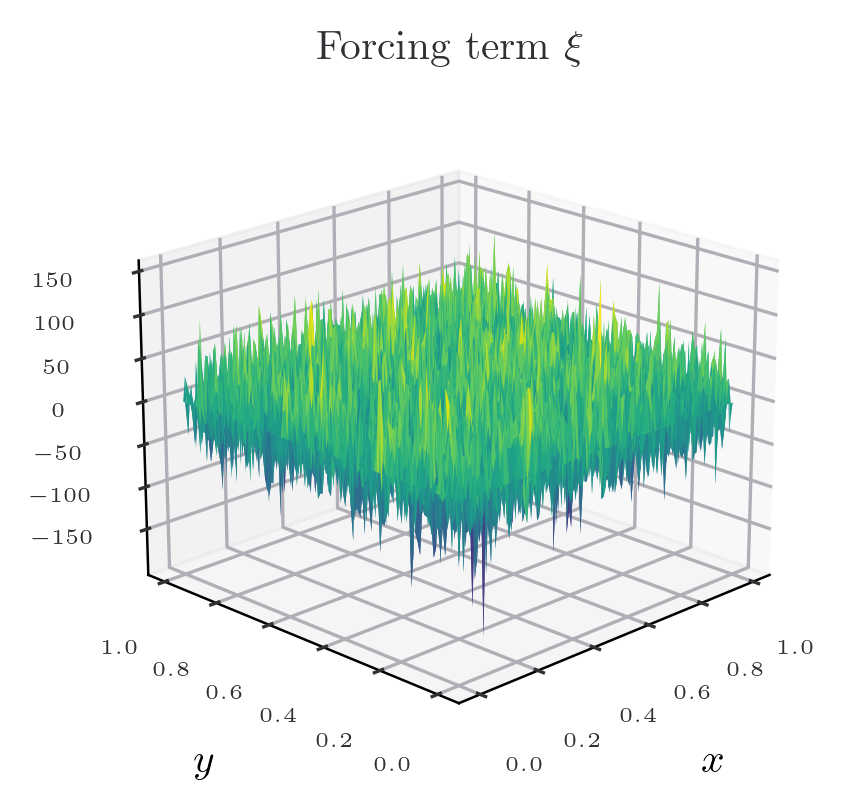

In [54]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [55]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
coef_f = f_trans
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


# Solve the linear PDE

In [56]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x, x, indexing='ij')

# Combine A and B into pairs
interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
print(interior.shape)

Number of points 64 (4096 measurements)
(4096, 2)


In [57]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


In [86]:
length_scale = 1.0
b_matrix = vmap_b(x, y)

In [87]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(f_trans[:n_points,:n_points], (n_points)*(n_points))])

In [88]:
theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
alpha = solve(theta, boundary_condition, f_trans[:n_points,:n_points], 0.5, reg_bc = 1e-10, reg = 1e-8)

In [89]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [90]:
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)

In [91]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.016035, dtype=float64), Array(0.0493662, dtype=float64))


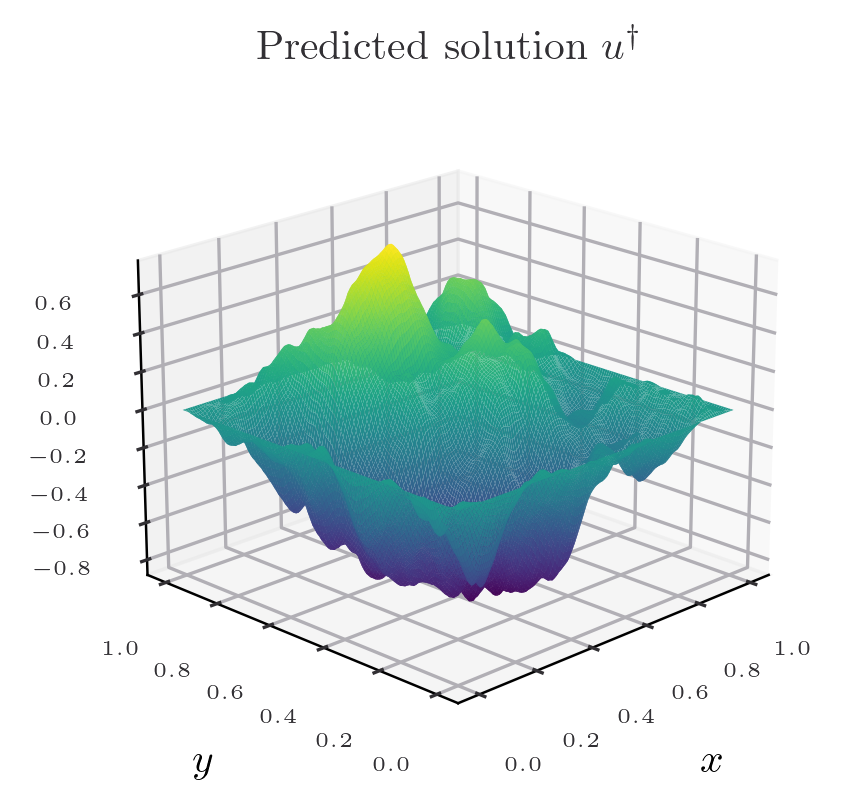

In [92]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

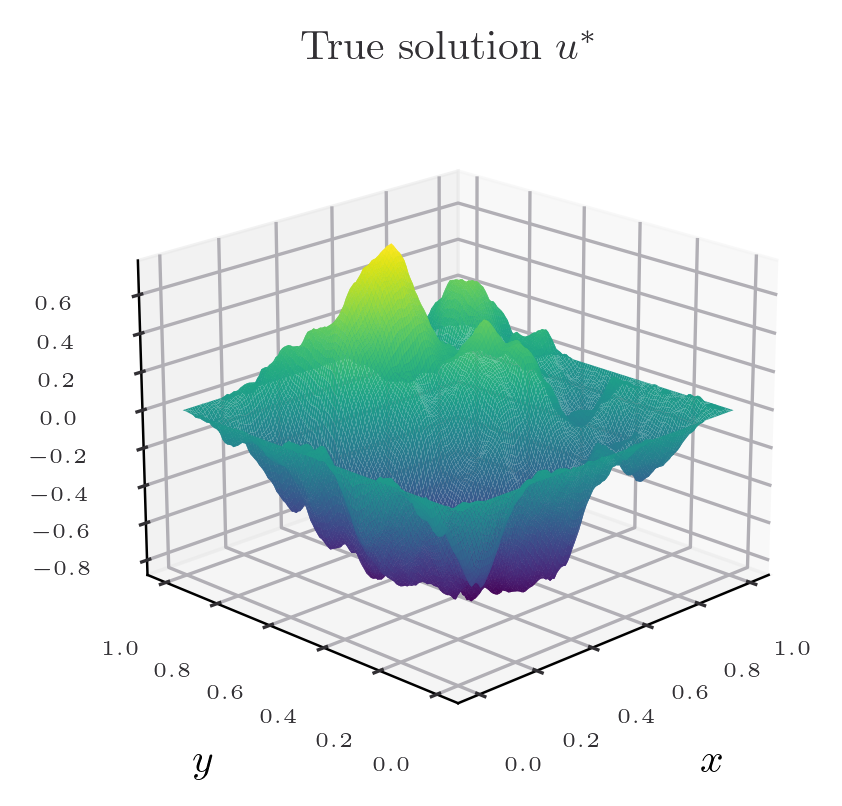

In [93]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

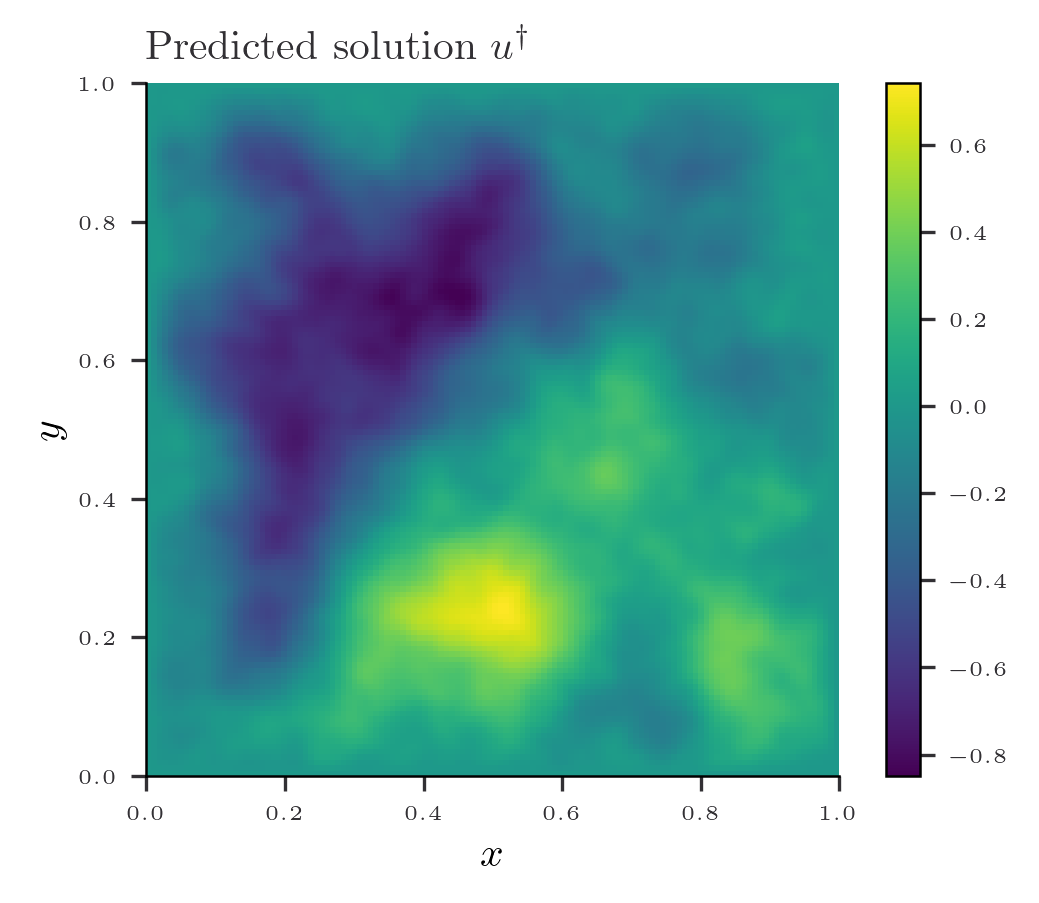

In [94]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

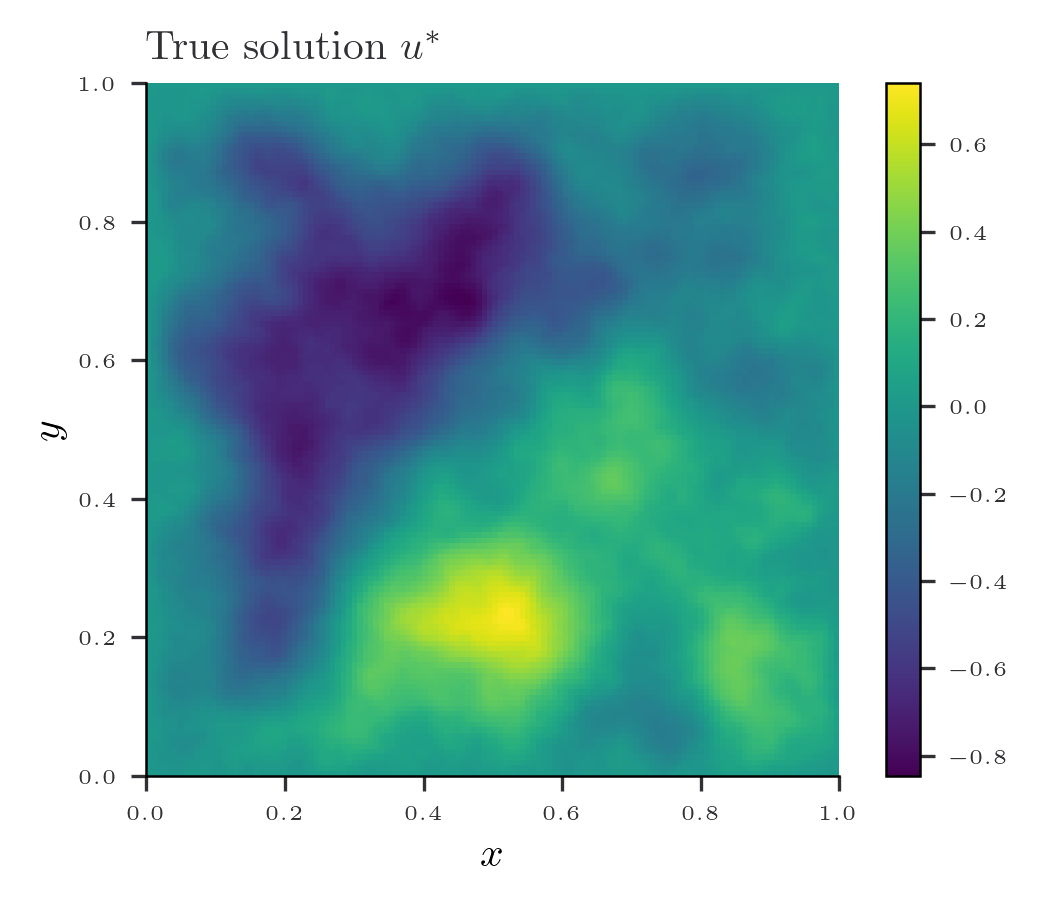

In [95]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

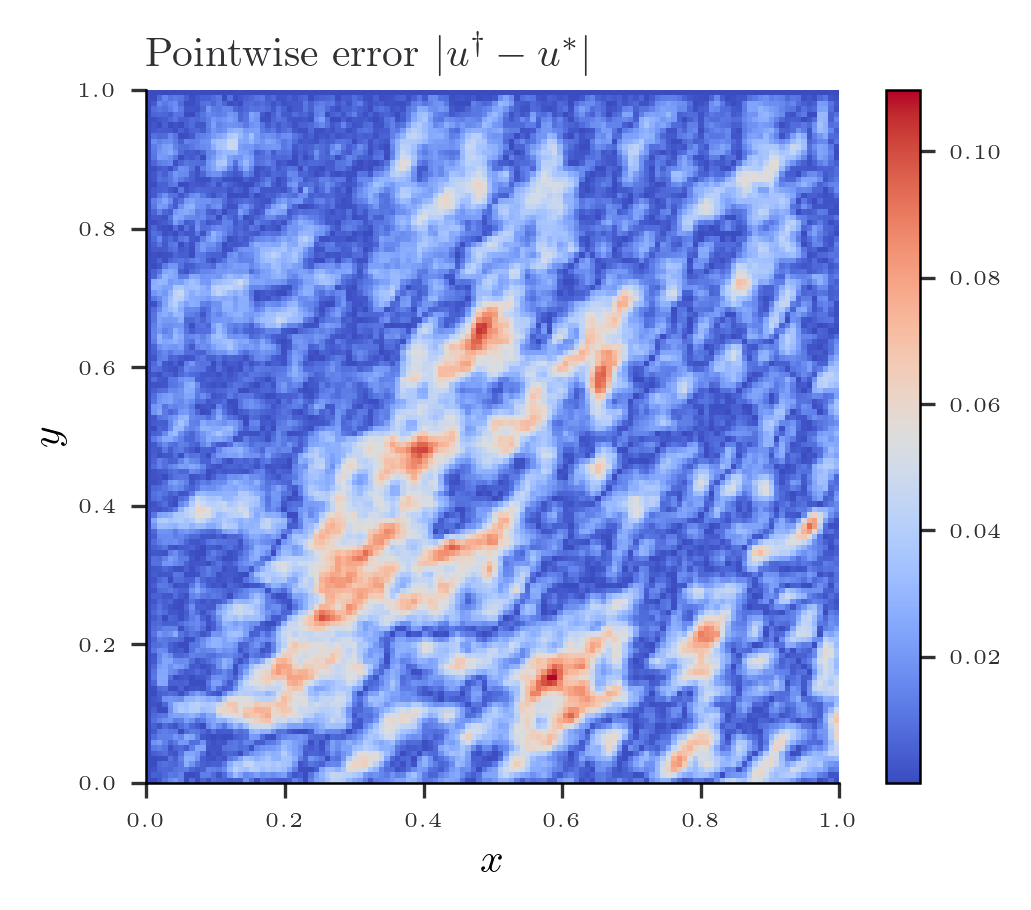

In [96]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

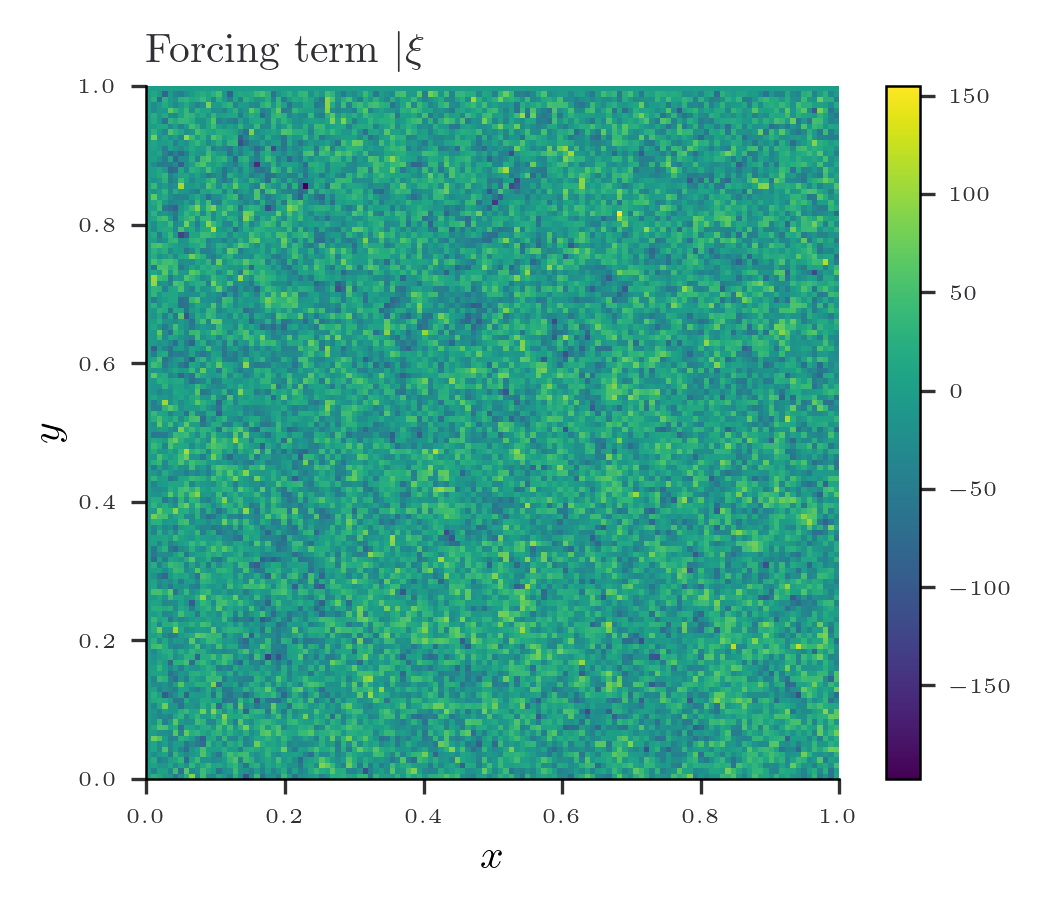

In [97]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $|\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Elliptic with coefficient

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\Delta u + b(x,y)u&= \xi \\
u &= 0
\end{aligned}

We will consider a manufactured solution

\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}

Then 

$$
\xi =  \sum_{k=1}^\infty\sum_{l=1}^\infty u_{kl}(l^2 + k^2)^{-\alpha -\delta}(\pi^2(l^2 + k^2) + b(x,y))\sin(\pi k x) \sin(\pi l y) )

In [98]:
key = random.PRNGKey(647023)
key = random.PRNGKey(558)
#key = random.PRNGKey(311)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

nu = 1e-1
b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.0
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))


Number of coefficients:  128


In [99]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values

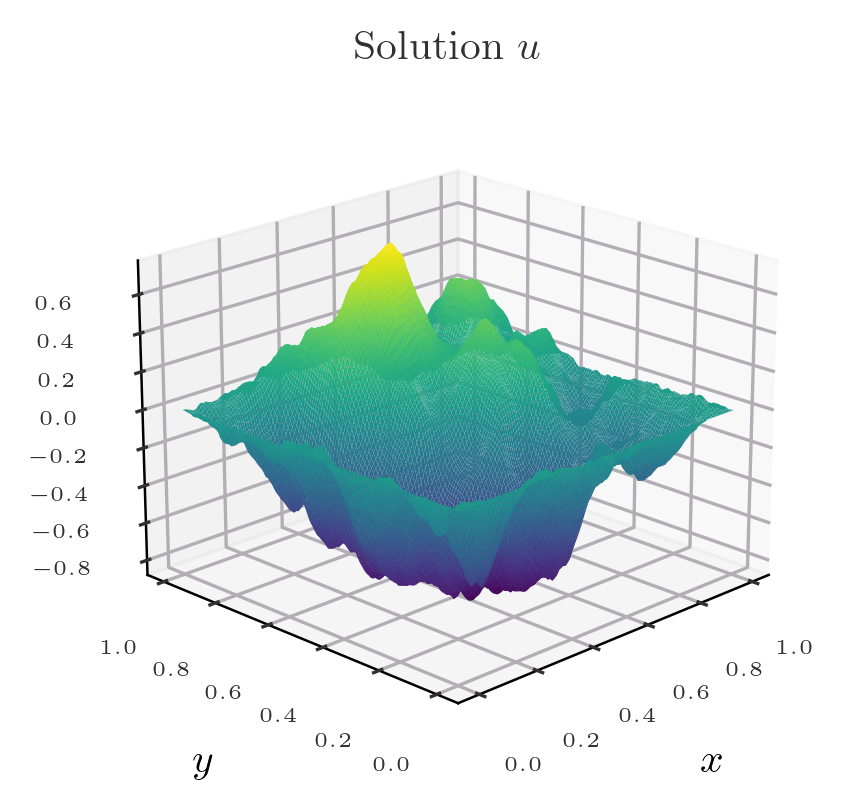

In [100]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

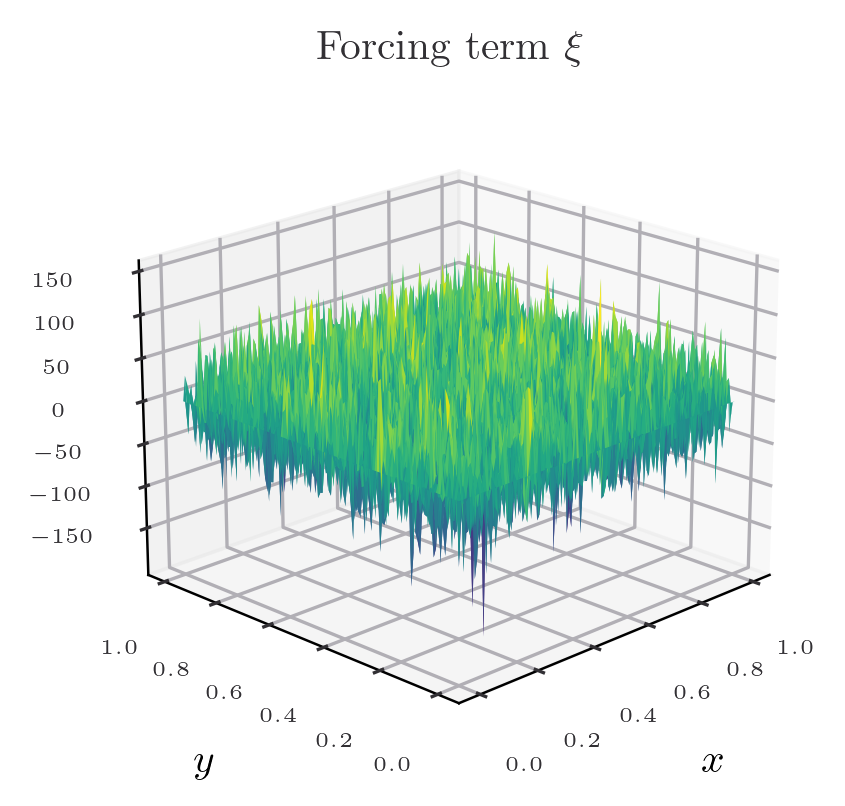

In [101]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [102]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
coef_f = f_trans
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


In [103]:
length_scale = 1.0
b_matrix = vmap_b(x, y)

In [104]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(f_trans[:n_points,:n_points], (n_points)*(n_points))])

In [105]:
theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
alpha = solve(theta, boundary_condition, f_trans[:n_points,:n_points], 0.5, reg_bc = 1e-10, reg = 1e-8)

In [106]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [107]:
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)

In [115]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01570323, dtype=float64), Array(0.0483448, dtype=float64))


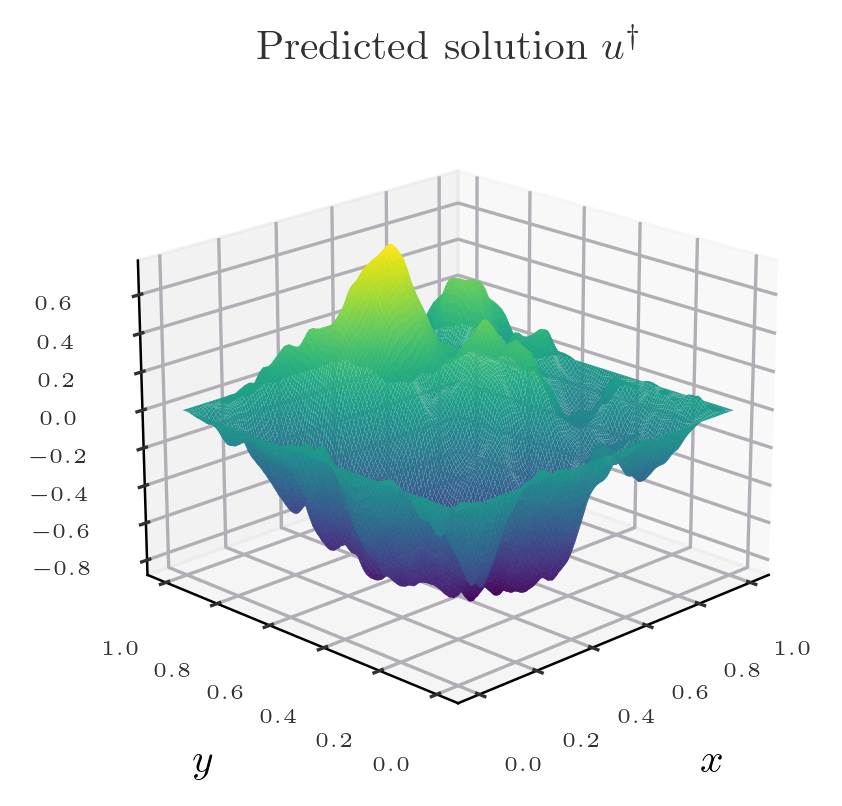

In [108]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

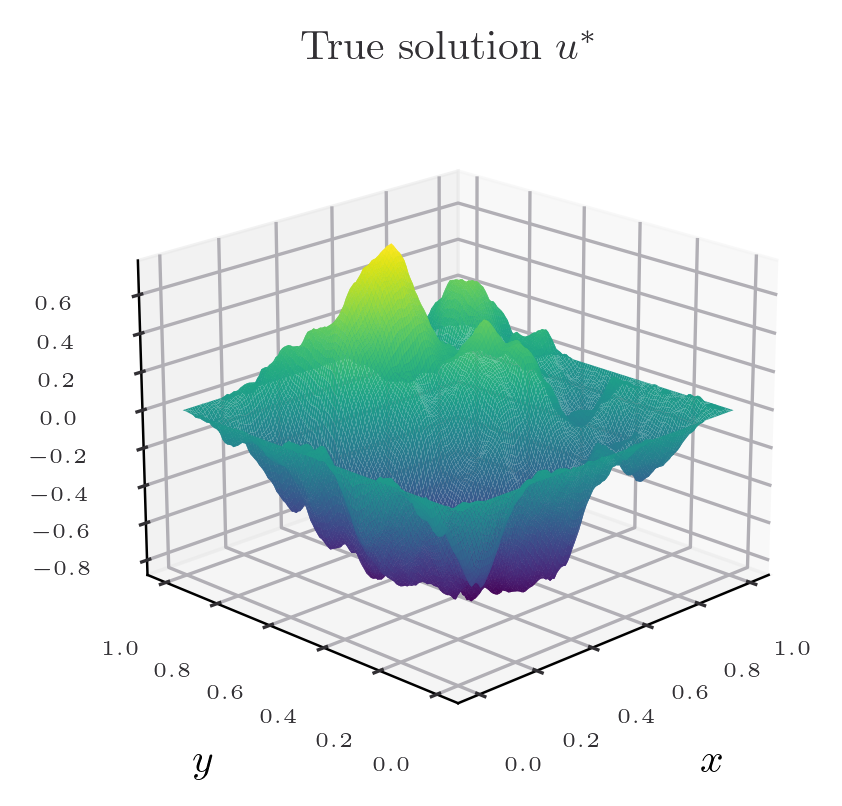

In [109]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

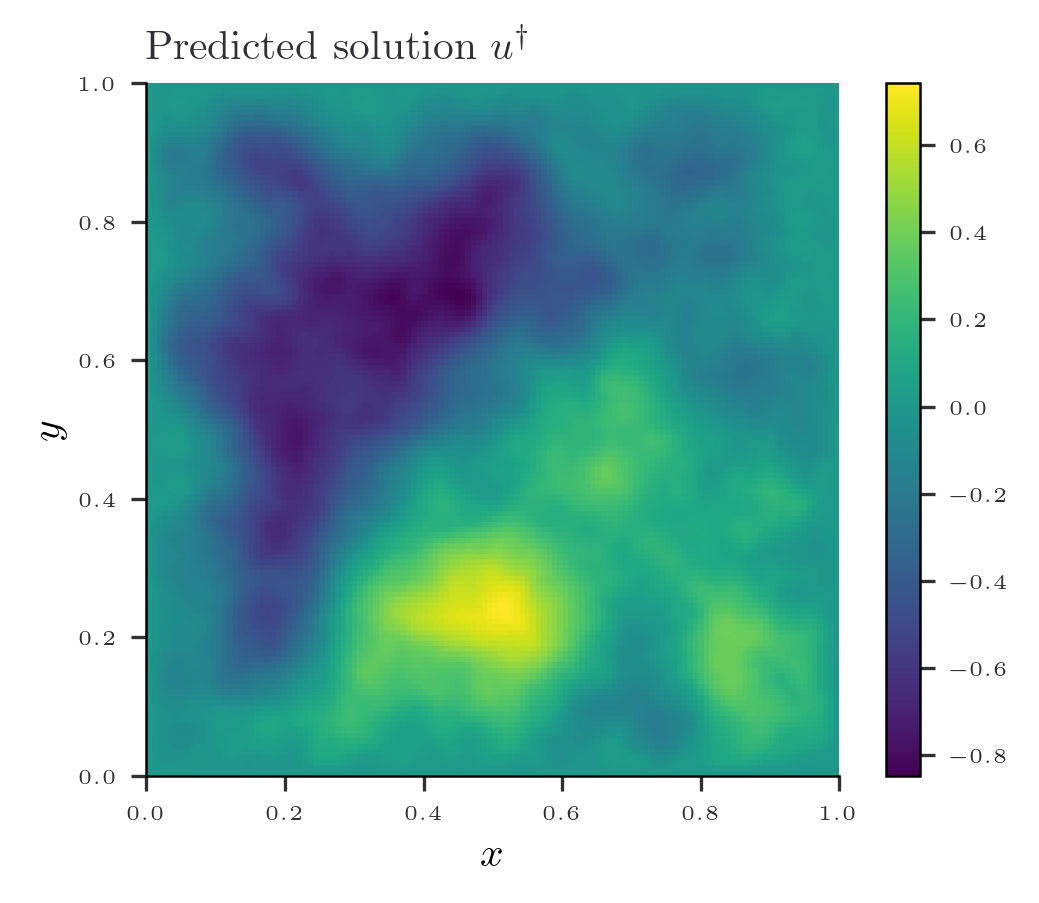

In [111]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

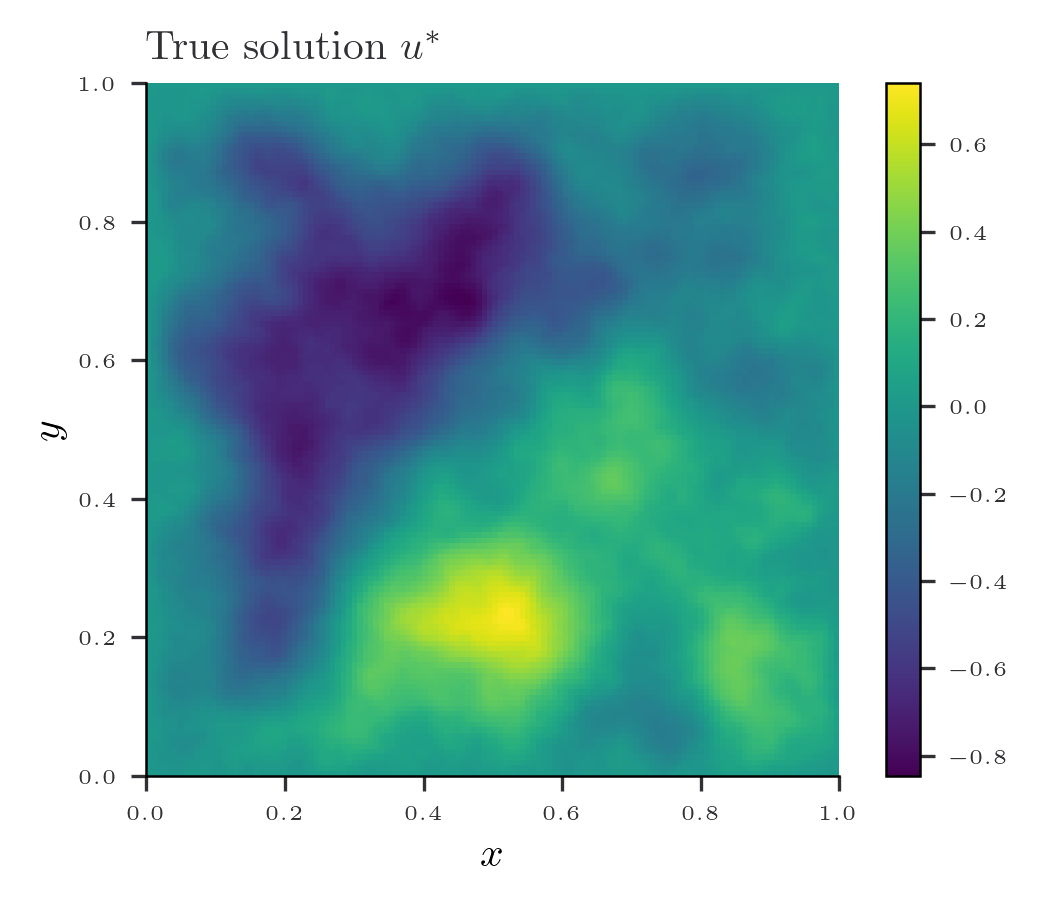

In [112]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

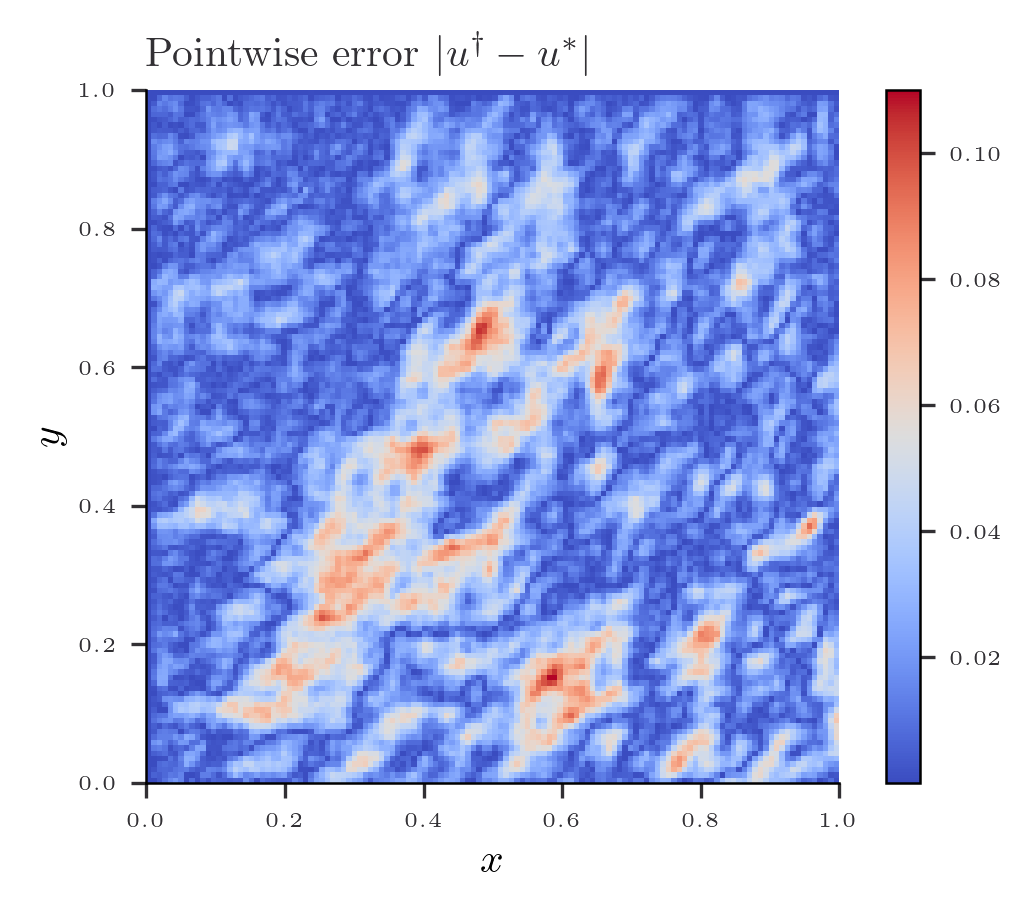

In [113]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

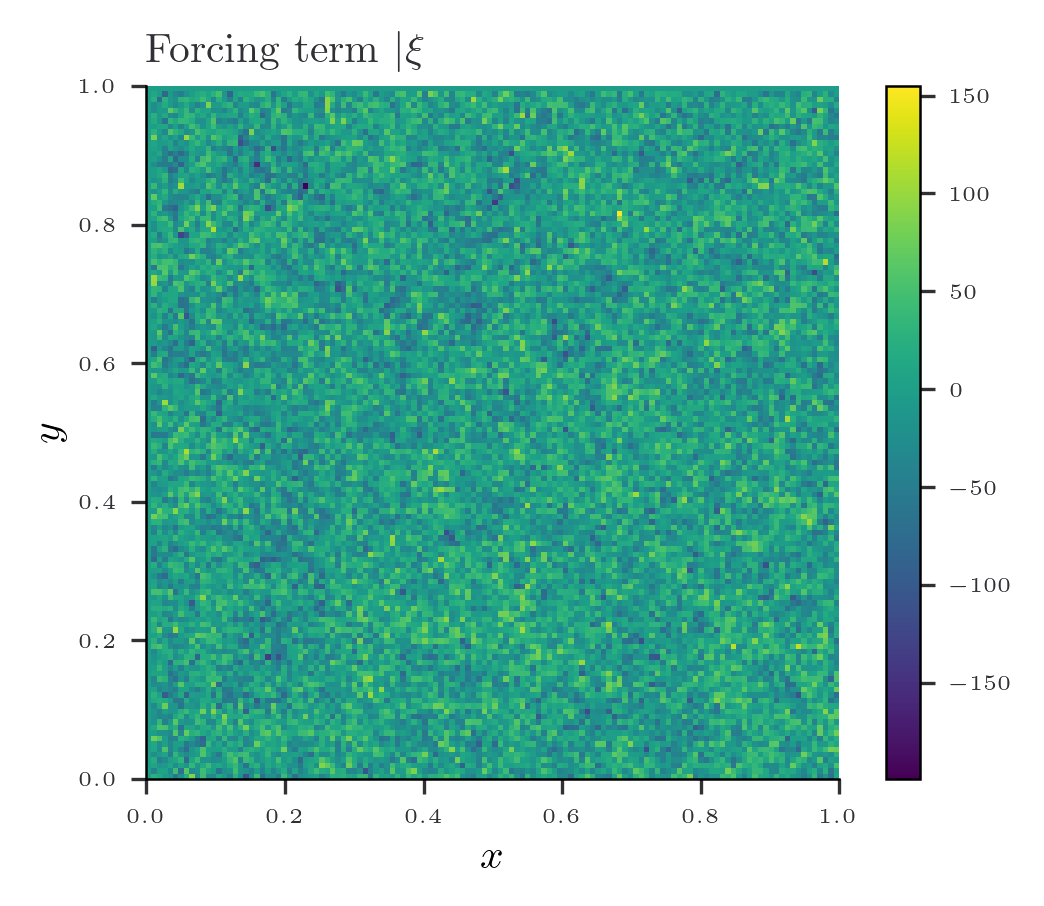

In [114]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $|\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [42]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [43]:
key = random.PRNGKey(558)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

c = 1.0
beta = 0.5

nu = 1e-1
b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)

vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))



Number of coefficients:  128


In [44]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)


# tau = jit(lambda x: x**3/3)
# tau_prime = jit(lambda x: x**2)

In [45]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values) #c*jnp.sin(beta*2*jnp.pi*u_values)

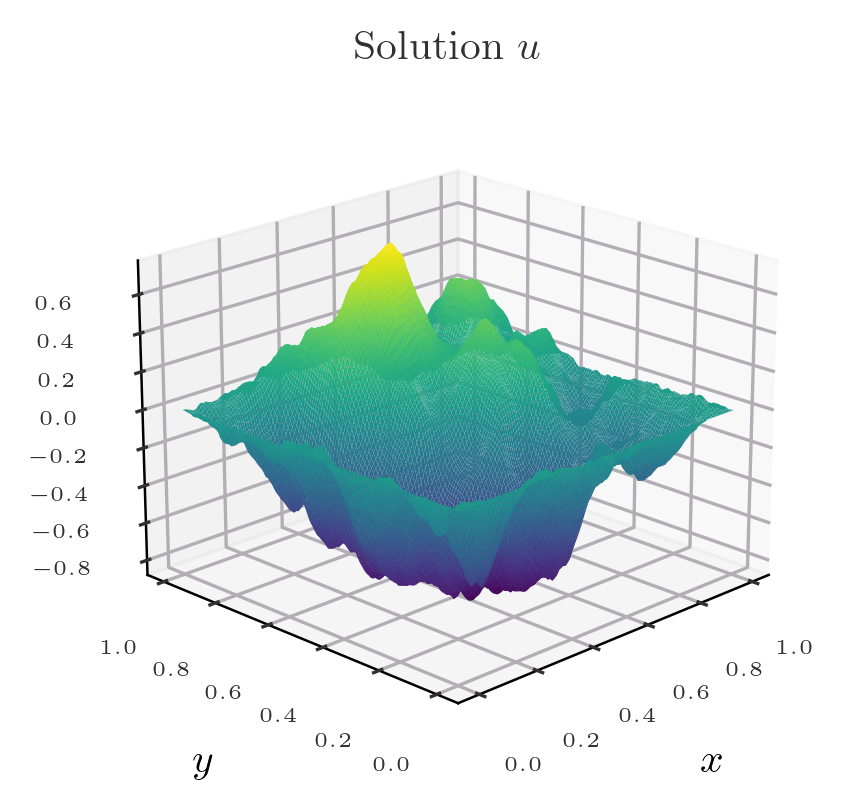

In [46]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

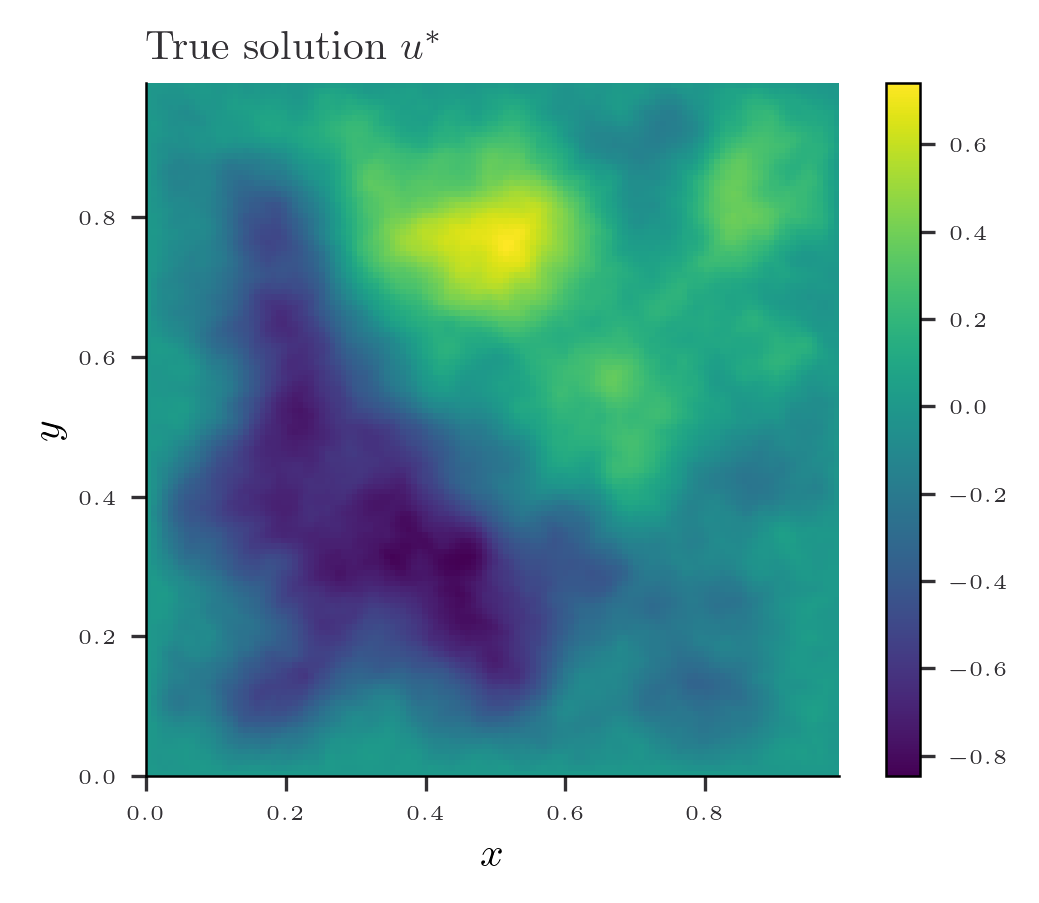

In [47]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

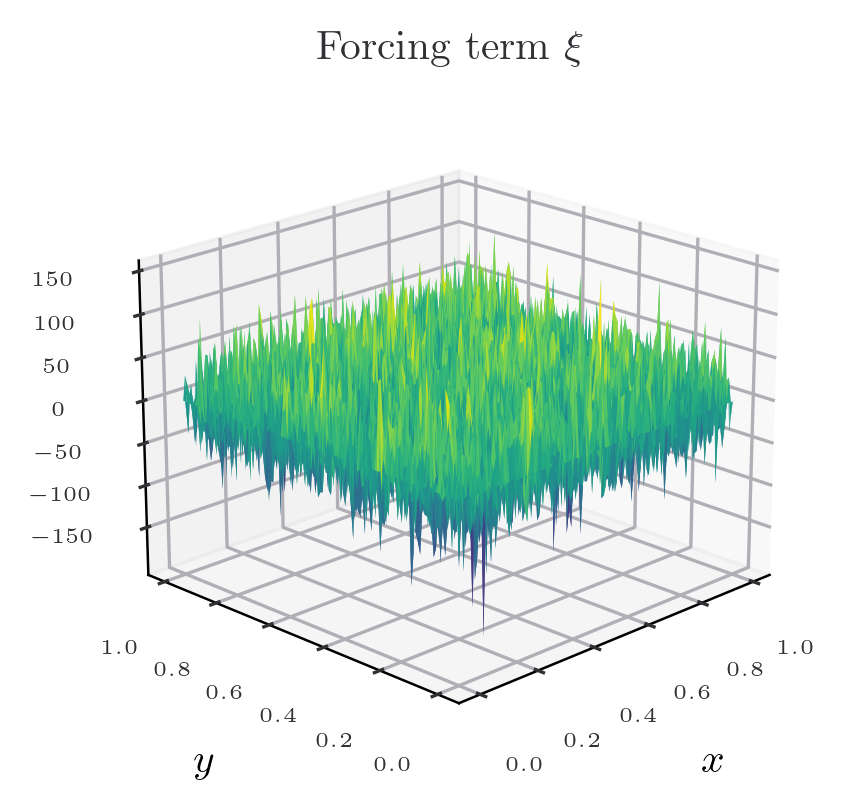

In [48]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

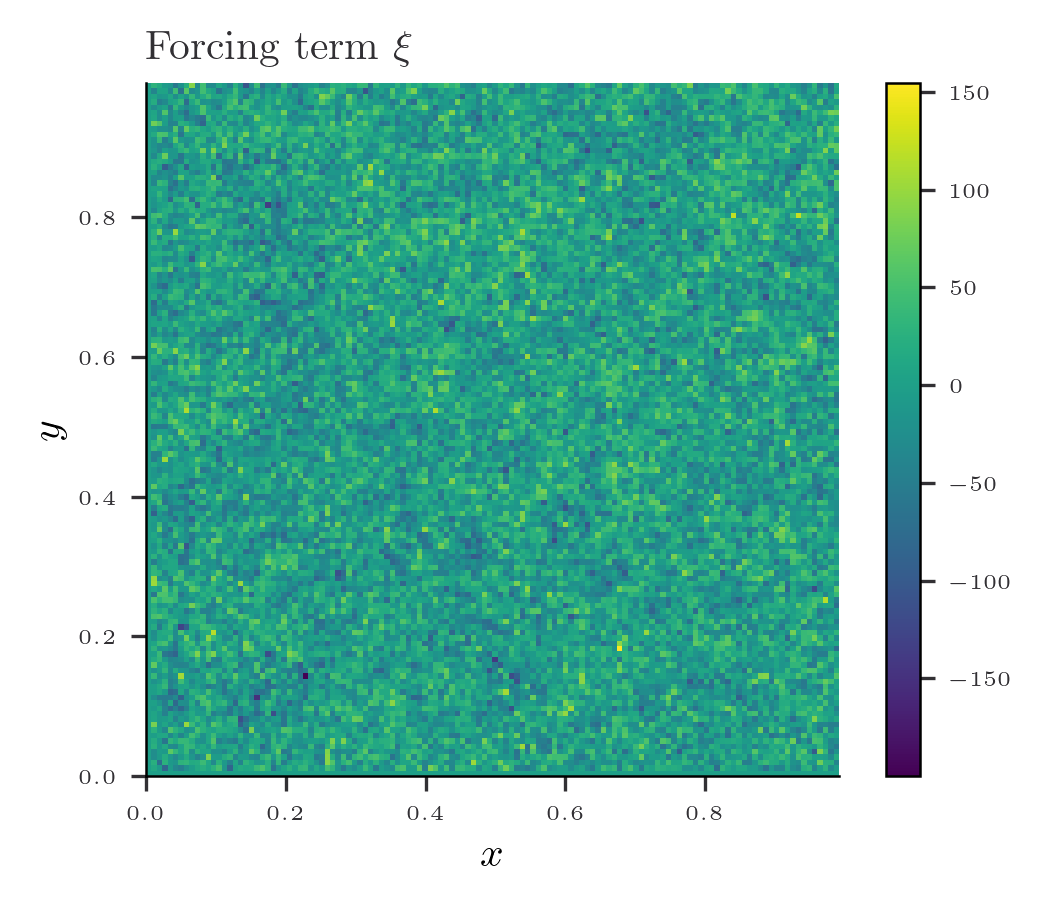

In [49]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [50]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


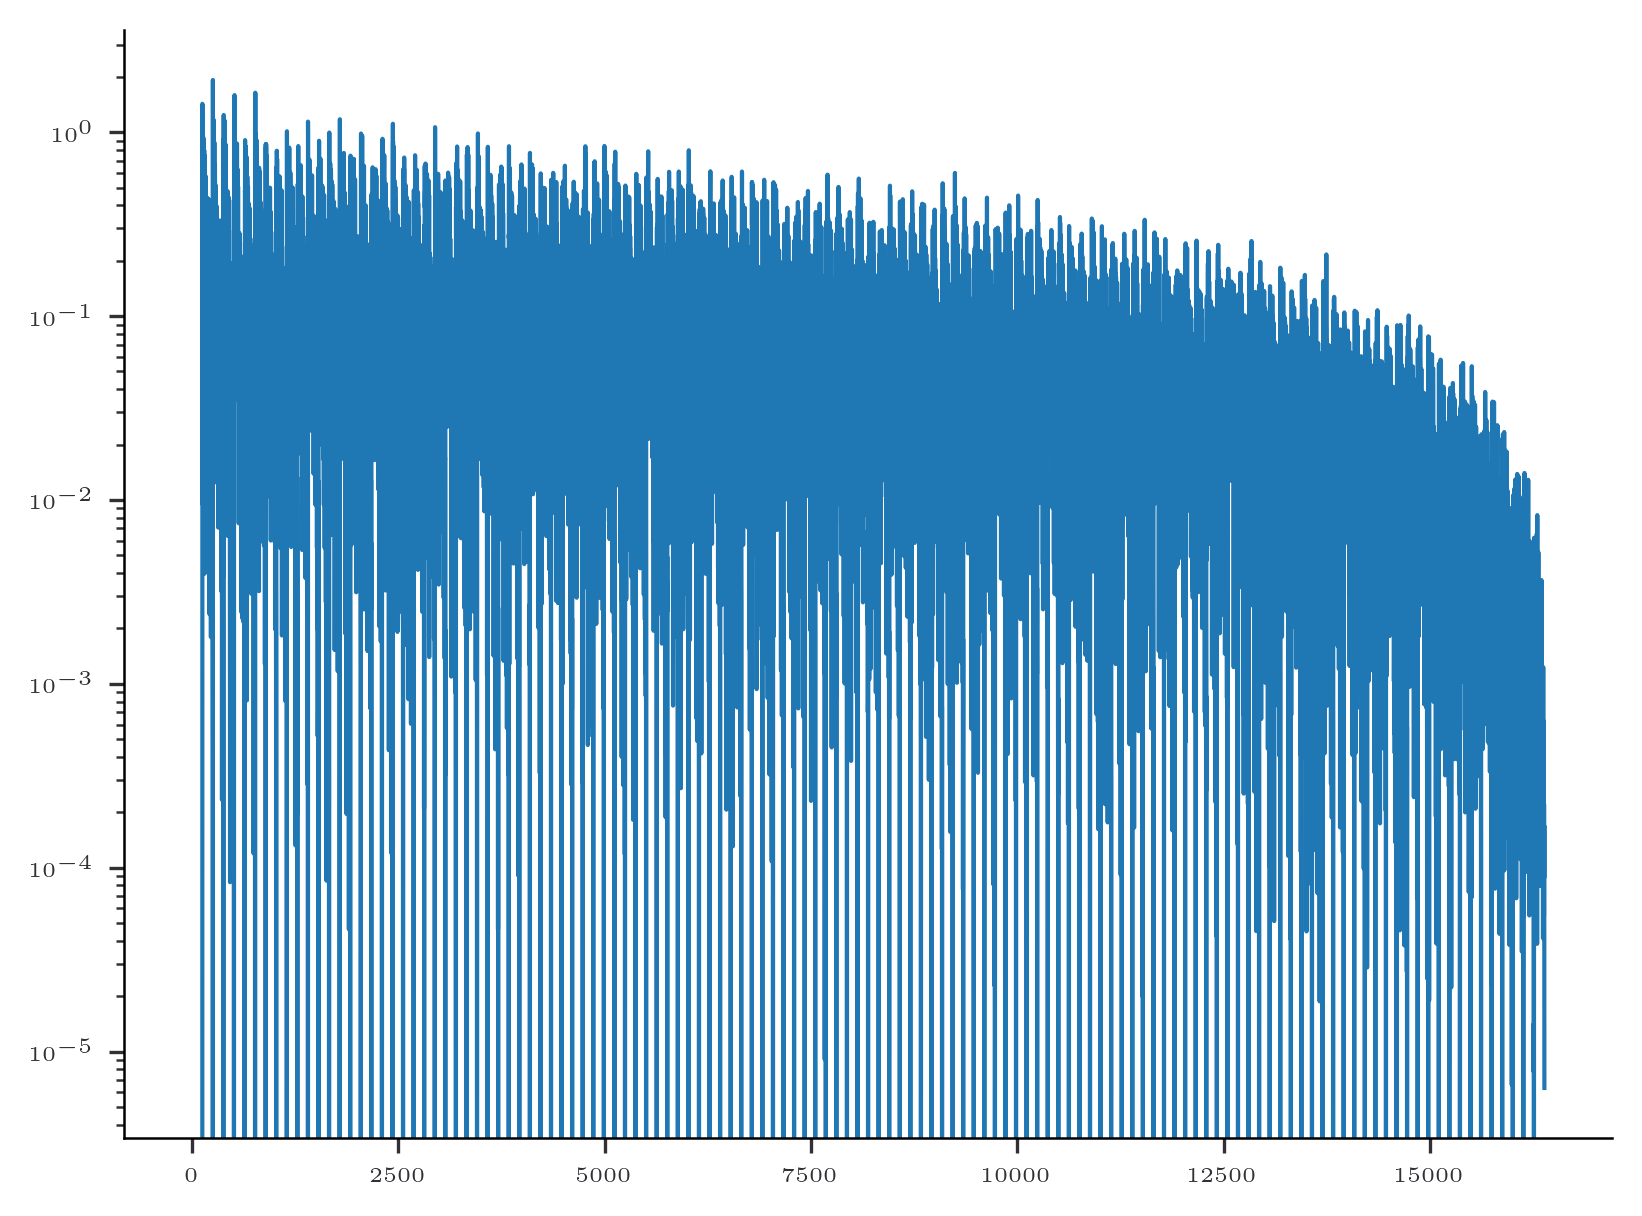

In [51]:
plt.plot(jnp.abs(f_trans.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

In [52]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

interior = create_interior(x, y)

Number of points 64 (4096 measurements)


In [53]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


In [54]:
length_scale = 0.5
b_matrix = vmap_b(x, y)

In [25]:
rhs = jnp.hstack([boundary_condition, jnp.reshape(f_trans[:n_points,:n_points], (n_points)*(n_points))])

In [26]:
theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
alpha = solve(theta, boundary_condition, f_trans[:n_points,:n_points], 0.5, reg_bc = 1e-10, reg = 1e-8)

In [27]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)

interior_eval = create_interior(x_eval, y_eval)

u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [28]:
pred_grid, pred = predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)

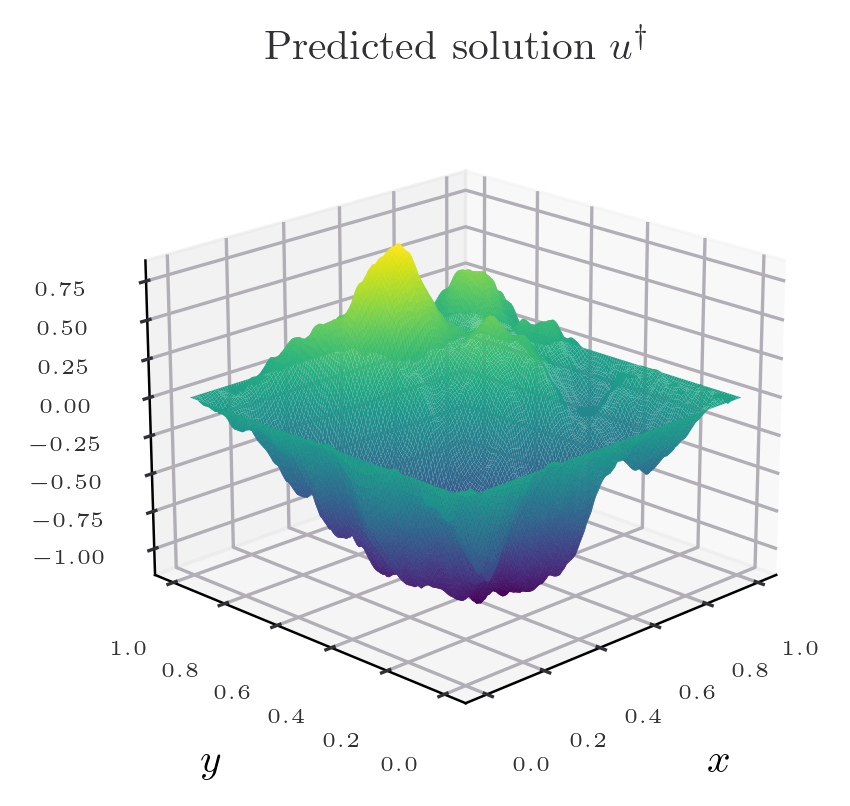

In [29]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

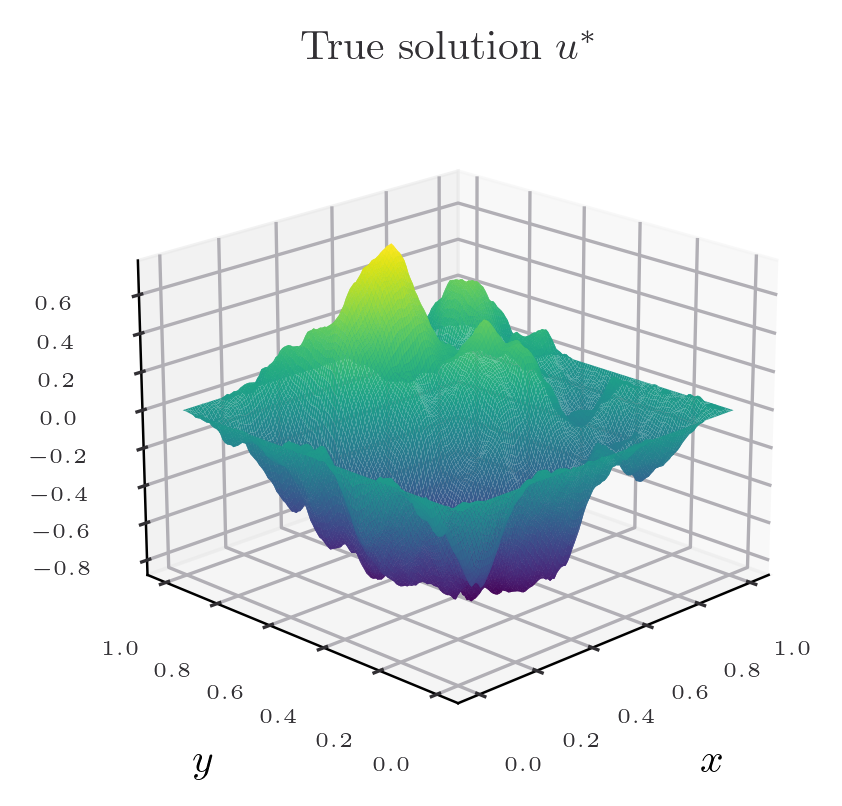

In [30]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [31]:
# norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
# norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.12650655, dtype=float64), Array(0.38946977, dtype=float64))


## Setting up the Gauss-Newton algorithm



With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.


In [32]:
f_observed =  f_trans[:n_points,:n_points]

In [33]:
f_observed.shape

(64, 64)

In [34]:
b_matrix
b_matrix_linear = jnp.copy(b_matrix)

In [35]:
u_grid = evaluate_basis_sine_2d(x,y, coef_u)

In [36]:
def Gauss_Newton(f, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, reg, reg_bc):
    b_matrix = jnp.copy(b_matrix_linear)
    r_n = f
    n_points = f.shape[0]
    best_error = jnp.inf
    
    for i in range(n_iter):
        print("Current iteration {}".format(i+1))

        # Build the matrix and sovle the system
        theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
        alpha = solve(theta, boundary_condition, r_n, 0.5, reg_bc = reg_bc, reg = reg)

        # Evaluate on the grid
        pred_grid, pred = predict(alpha, x, y, x,y, boundary_points, length_scale, nu, b_matrix)

        # Evaluate the DST transform of  negative laplacian 
        K_laplacian_dst = jnp.vstack([theta_12_dst, theta_22_dst]).T
        L_dst = K_laplacian_dst@alpha

        # Compute the discrepancy with f
        error = jnp.linalg.norm(L_dst + dst_2d(tau(pred_grid)).reshape(n_points*n_points) - f.reshape(n_points*n_points))/jnp.linalg.norm(f.reshape(n_points*n_points))
        _, error_truth = compute_2d_error(pred_grid, u_grid, x, y)
        print(error, error_truth)


        if i < n_iter-1:
            # Compute the linearization
            linearization = tau_prime(pred_grid)*pred_grid - tau(pred_grid)
            # Project on the sine basis
            linearization = dst_2d(linearization)
            # Compute the residual
            r_n = f + linearization

            # Compute the new coefficent b
            b_matrix = b_matrix_linear + tau_prime(pred_grid)
    return alpha, b_matrix
    

In [37]:
length_scale = 1.0

In [38]:
n_iter = 10
alpha, b_matrix =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, reg = 1e-7, reg_bc = 1e-10)

Current iteration 1
0.5930532580631425 0.38578071246786194
Current iteration 2
0.5937080163951921 0.24412869813767696
Current iteration 3
0.5924556689632606 0.07271462930313034
Current iteration 4
0.5926278181969533 0.06025936079479385
Current iteration 5
0.5926672377338656 0.06051702369022097
Current iteration 6
0.5926666989221593 0.06050413646292062
Current iteration 7
0.592666729590322 0.060504754704407485
Current iteration 8
0.5926667281205832 0.060504719365071194
Current iteration 9
0.592666728204386 0.06050472360590717
Current iteration 10
0.59266672819542 0.06050472223367209


In [59]:
def Gauss_Newton(f, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, start_reg, end_reg, reg_bc):
    b_matrix = jnp.copy(b_matrix_linear)
    r_n = f
    n_points = f.shape[0]
    best_error = jnp.inf
    best_error_truth = jnp.inf

    reg = start_reg
    
    for i in range(n_iter):
        #print("Current iteration {}".format(i+1))

        # Build the matrix and sovle the system
        theta, theta_11, theta_12_dst, theta_22_dst = build_matrices(boundary_points,x,y,length_scale, b_matrix, nu)
        alpha = solve(theta, boundary_condition, r_n, 0.5, reg_bc = reg_bc, reg = reg)

        # Evaluate on the grid
        pred_grid, pred = predict(alpha, x, y, x,y, boundary_points, length_scale, nu, b_matrix)

        # Evaluate the DST transform of  negative laplacian 
        K_laplacian_dst = jnp.vstack([theta_12_dst, theta_22_dst]).T
        L_dst = K_laplacian_dst@alpha

        # Compute the discrepancy with f
        error = jnp.linalg.norm(L_dst + dst_2d(tau(pred_grid)).reshape(n_points*n_points) - f.reshape(n_points*n_points))/jnp.linalg.norm(f.reshape(n_points*n_points))
        _, error_truth = compute_2d_error(pred_grid, u_grid, x, y)
        #print(error, error_truth)
        if error < best_error:
            best_error = error
            best_error_truth = error_truth
            best_alpha = alpha
            best_b_matrix = b_matrix

            # Compute the linearization
            linearization = tau_prime(pred_grid)*pred_grid - tau(pred_grid)
            # Project on the sine basis
            linearization = dst_2d(linearization)
            # Compute the residual
            r_n = f + linearization

            # Compute the new coefficent b
            b_matrix = b_matrix_linear + tau_prime(pred_grid)

        else:
            reg = reg*0.9
            if reg <end_reg:
                break
            print("Converged, new regularization {} (best error {}, best error truth {})".format(reg, best_error, best_error_truth))



    print("Best error achieved: {} (best error truth {})".format(best_error, best_error_truth))
    return best_alpha, best_b_matrix
    

In [70]:
n_iter = 10**5
length_scale = 1.0
alpha, b_matrix =  Gauss_Newton(f_observed, boundary_condition, b_matrix_linear,boundary_points, x,y,length_scale, nu, n_iter, start_reg = 1e-1, end_reg = 1e-7, reg_bc = 1e-10)

Converged, new regularization 0.09000000000000001 (best error 0.99689671208088, best error truth 0.8547071600439758)
Converged, new regularization 0.08100000000000002 (best error 0.9966920130764193, best error truth 0.8450263322814191)
Converged, new regularization 0.07290000000000002 (best error 0.9964525197638022, best error truth 0.8336143234236529)
Converged, new regularization 0.06561000000000002 (best error 0.9962056596506899, best error truth 0.821752393750584)
Converged, new regularization 0.05904900000000002 (best error 0.9959506893386781, best error truth 0.8093781759387864)
Converged, new regularization 0.05314410000000002 (best error 0.9956885567267866, best error truth 0.7965179298214385)
Converged, new regularization 0.04782969000000002 (best error 0.995420167008478, best error truth 0.7831981789359268)
Converged, new regularization 0.043046721000000024 (best error 0.9951464619496566, best error truth 0.769451668485081)
Converged, new regularization 0.03874204890000002 (b

In [71]:
pred_grid, pred= predict(alpha, x_eval, y_eval, x,y, boundary_points, length_scale, nu, b_matrix)

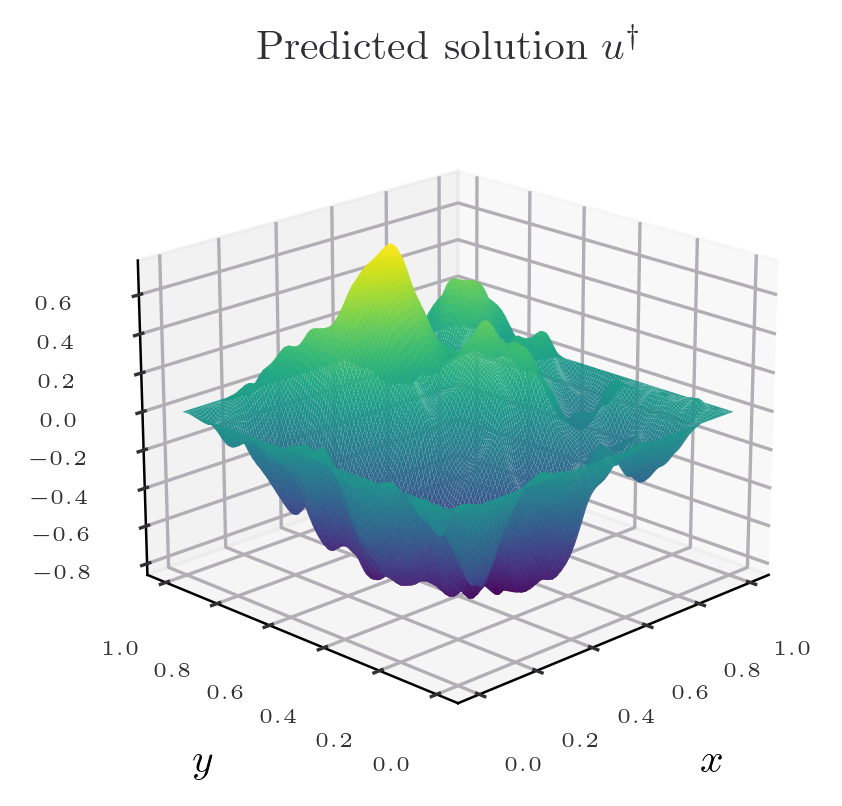

In [72]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

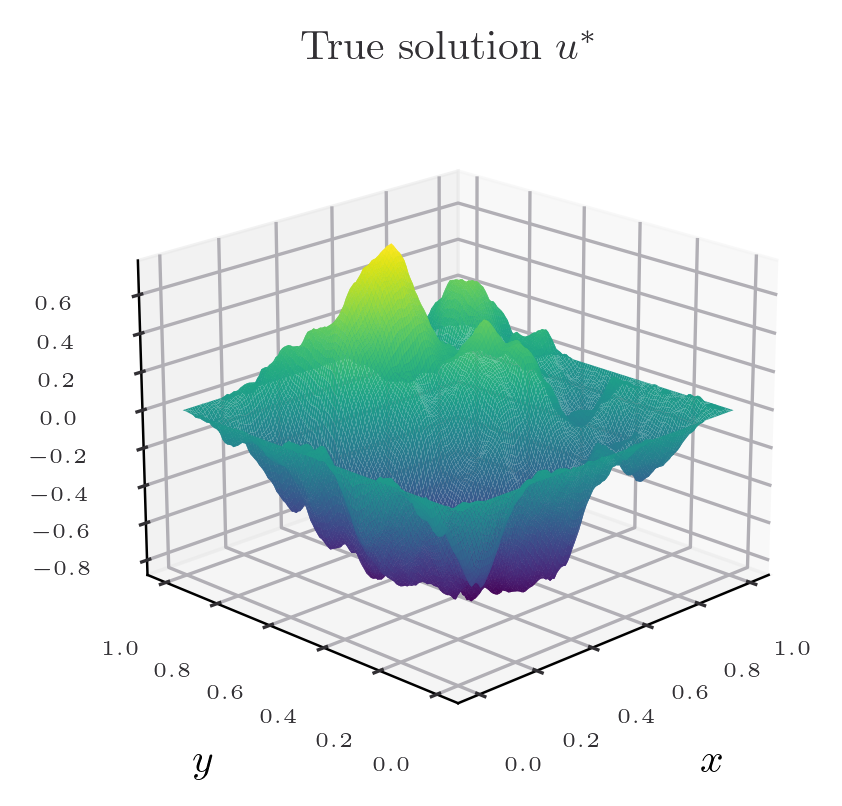

In [73]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [74]:
norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred_grid - u_eval)**2, x_eval), y_eval))
norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u_eval**2, x_eval), y_eval))
print(norm_diff, norm_diff/norm_u)

0.019576285402315374 0.060268591242902826


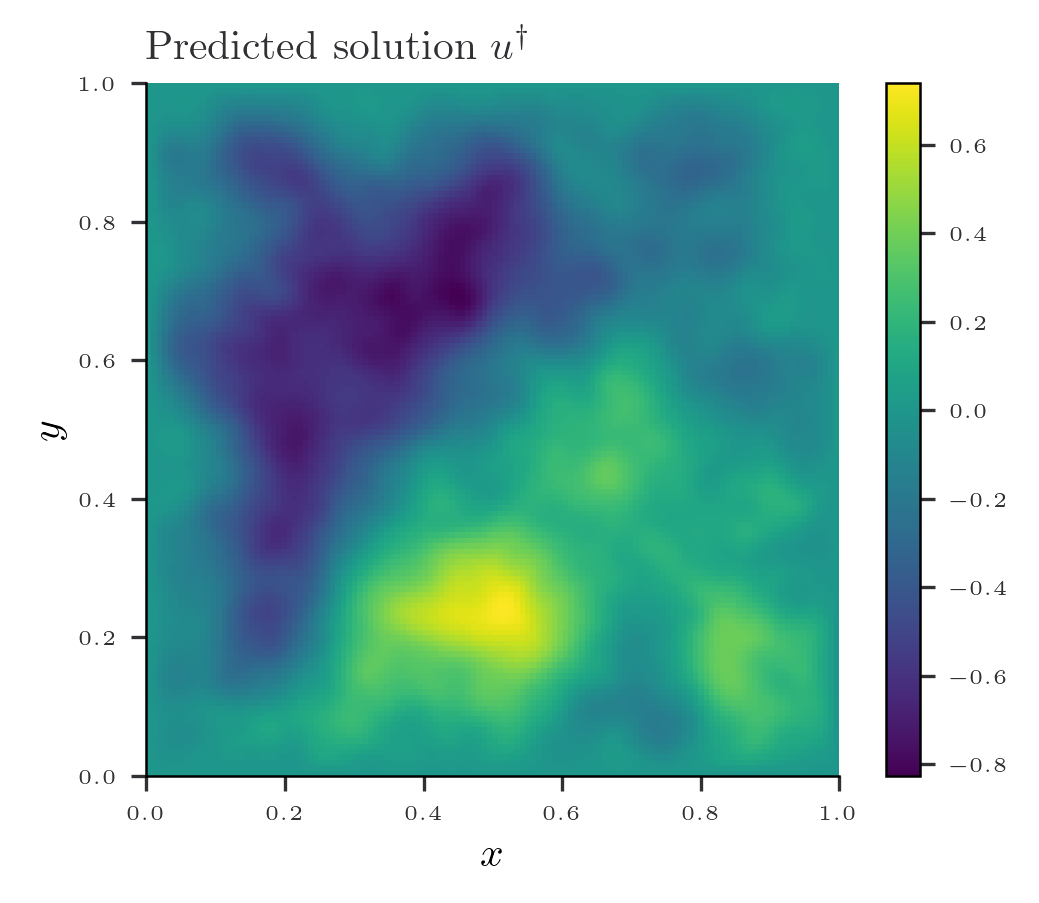

In [43]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

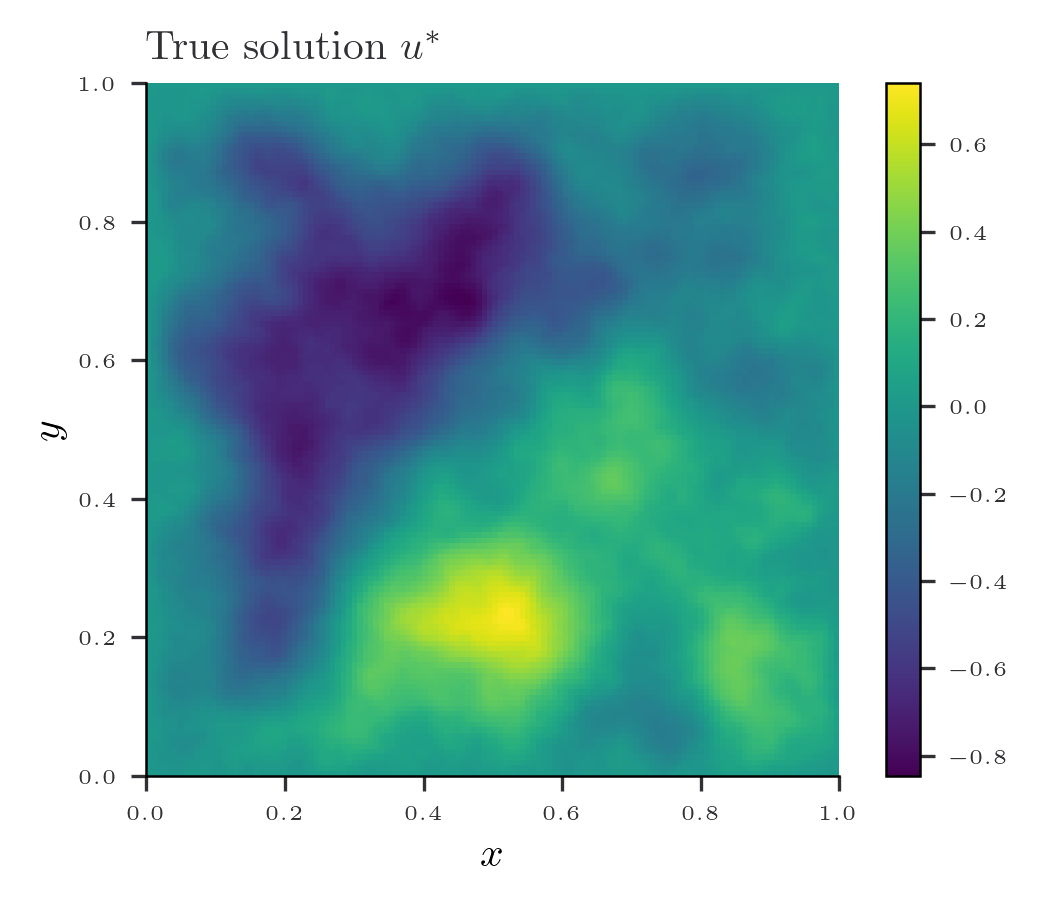

In [44]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

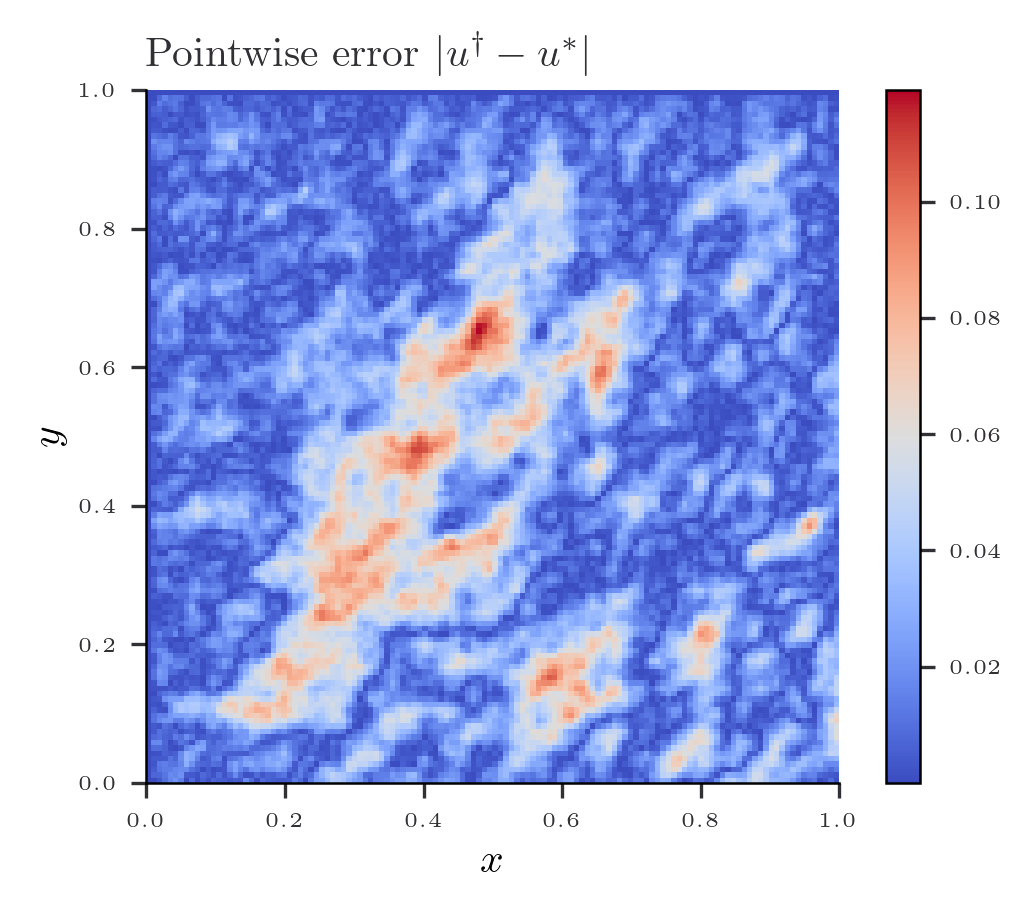

In [45]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()